In [1]:
%matplotlib inline


# Structural similarity index


When comparing images, the mean squared error (MSE)--while simple to
implement--is not highly indicative of perceived similarity.  Structural
similarity aims to address this shortcoming by taking texture into account
[1]_, [2]_.

The example shows two modifications of the input image, each with the same MSE,
but with very different mean structural similarity indices.

.. [1] Zhou Wang; Bovik, A.C.; ,"Mean squared error: Love it or leave it? A new
       look at Signal Fidelity Measures," Signal Processing Magazine, IEEE,
       vol. 26, no. 1, pp. 98-117, Jan. 2009.

.. [2] Z. Wang, A. C. Bovik, H. R. Sheikh and E. P. Simoncelli, "Image quality
       assessment: From error visibility to structural similarity," IEEE
       Transactions on Image Processing, vol. 13, no. 4, pp. 600-612,
       Apr. 2004.



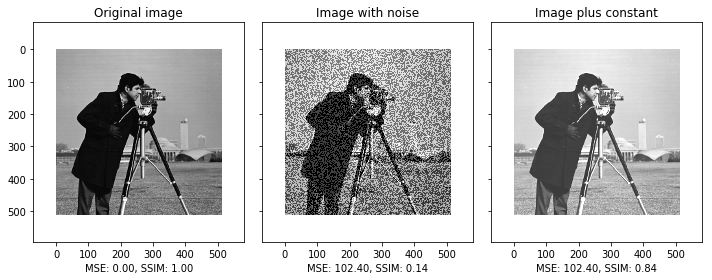

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim


img = img_as_float(data.camera())
rows, cols = img.shape

noise = np.ones_like(img) * 0.2 * (img.max() - img.min())
noise[np.random.random(size=noise.shape) > 0.5] *= -1

def mse(x, y):
    return np.linalg.norm(x - y)

img_noise = img + noise
img_const = img + abs(noise)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

mse_none = mse(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())

mse_noise = mse(img, img_noise)
ssim_noise = ssim(img, img_noise,
                  data_range=img_noise.max() - img_noise.min())

mse_const = mse(img, img_const)
ssim_const = ssim(img, img_const,
                  data_range=img_const.max() - img_const.min())

label = 'MSE: {:.2f}, SSIM: {:.2f}'

ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_xlabel(label.format(mse_none, ssim_none))
ax[0].set_title('Original image')

ax[1].imshow(img_noise, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_xlabel(label.format(mse_noise, ssim_noise))
ax[1].set_title('Image with noise')

ax[2].imshow(img_const, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[2].set_xlabel(label.format(mse_const, ssim_const))
ax[2].set_title('Image plus constant')

plt.tight_layout()
plt.show()

In [3]:
import numpy as np
import tensorflow as tf
import t3f
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt
import metric_util as mt
import data_util as du
from t3f import shapes
from nilearn import image

In [4]:
subject_scan_path = du.get_full_path_subject1()
print "Subject Path: " + str(subject_scan_path)
x_true_org = mt.read_image_abs_path(subject_scan_path)


Subject Path: /work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii


In [7]:
print(x_true_org)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (53, 63, 46, 144)
affine: 
[[  -3.    0.    0.   78.]
 [   0.    3.    0. -111.]
 [   0.    0.    3.  -51.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : 
db_name         : 
extents         : 0
session_error   : 0
regular         : r
dim_info        : 0
dim             : [  4  53  63  46 144   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  3.  3.  3.  0.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : spm - 3D normalized
aux_file        : 
qform_code      : aligned
sform

In [21]:
x_hat = image.index_img(x_true_org,1)
x_hat_arr = np.array(x_hat.get_data())

In [5]:

from scipy import misc


TypeError: Invalid dimensions for image data

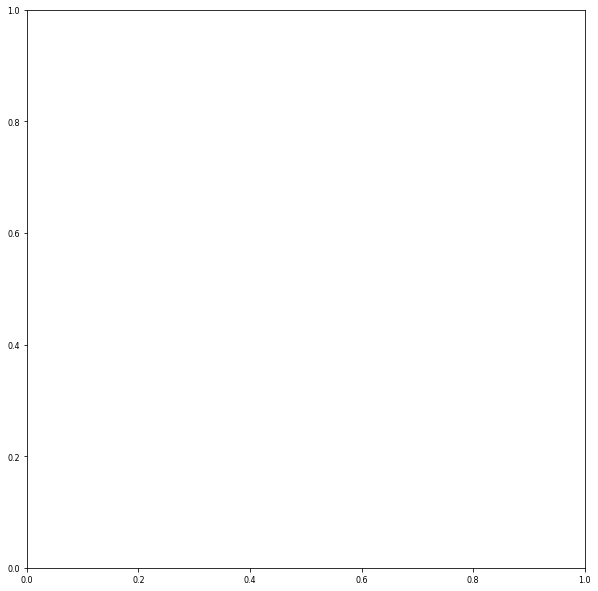

In [13]:
plt.figure(figsize=(10,20))
plt.imshow(x_hat_arr)

In [14]:
x_hat_arr.shape

(53, 63, 46)

In [16]:
x_hat_arr_norm=np.linalg.norm(x_hat_arr)

In [17]:
x_hat_arr = x_hat_arr/x_hat_arr_norm

In [22]:
ssim_const = ssim(x_hat_arr, x_hat_arr,
                  data_range=x_hat_arr.max() - x_hat_arr.min())

In [23]:
ssim_const

1.0

In [32]:
from __future__ import division

import numpy as np
from scipy.ndimage import uniform_filter, gaussian_filter

from skimage.util.dtype import dtype_range
from skimage.util.arraycrop import crop
from skimage._shared.utils import deprecated
from skimage._shared.utils import skimage_deprecation, warn

In [98]:
__all__ = ['compare_ssim']


def compare_ssim_custom(X, Y, win_size=None, gradient=False,
                 data_range=None, multichannel=False, gaussian_weights=False,
                 full=False, **kwargs):
    """Compute the mean structural similarity index between two images.
    Parameters
    ----------
    X, Y : ndarray
        Image.  Any dimensionality.
    win_size : int or None
        The side-length of the sliding window used in comparison.  Must be an
        odd value.  If `gaussian_weights` is True, this is ignored and the
        window size will depend on `sigma`.
    gradient : bool, optional
        If True, also return the gradient with respect to Y.
    data_range : float, optional
        The data range of the input image (distance between minimum and
        maximum possible values).  By default, this is estimated from the image
        data-type.
    multichannel : bool, optional
        If True, treat the last dimension of the array as channels. Similarity
        calculations are done independently for each channel then averaged.
    gaussian_weights : bool, optional
        If True, each patch has its mean and variance spatially weighted by a
        normalized Gaussian kernel of width sigma=1.5.
    full : bool, optional
        If True, return the full structural similarity image instead of the
        mean value.
    Other Parameters
    ----------------
    use_sample_covariance : bool
        if True, normalize covariances by N-1 rather than, N where N is the
        number of pixels within the sliding window.
    K1 : float
        algorithm parameter, K1 (small constant, see [1]_)
    K2 : float
        algorithm parameter, K2 (small constant, see [1]_)
    sigma : float
        sigma for the Gaussian when `gaussian_weights` is True.
    Returns
    -------
    mssim : float
        The mean structural similarity over the image.
    grad : ndarray
        The gradient of the structural similarity index between X and Y [2]_.
        This is only returned if `gradient` is set to True.
    S : ndarray
        The full SSIM image.  This is only returned if `full` is set to True.
    Notes
    -----
    To match the implementation of Wang et. al. [1]_, set `gaussian_weights`
    to True, `sigma` to 1.5, and `use_sample_covariance` to False.
    References
    ----------
    .. [1] Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P.
       (2004). Image quality assessment: From error visibility to
       structural similarity. IEEE Transactions on Image Processing,
       13, 600-612.
        +,
       DOI:10.1109/TIP.2003.819861
    .. [2] Avanaki, A. N. (2009). Exact global histogram specification
       optimized for structural similarity. Optical Review, 16, 613-621.
       http://arxiv.org/abs/0901.0065,
       DOI:10.1007/s10043-009-0119-z
    """
    if not X.dtype == Y.dtype:
        raise ValueError('Input images must have the same dtype.')

    if not X.shape == Y.shape:
        raise ValueError('Input images must have the same dimensions.')

    if multichannel:
        # loop over channels
        args = dict(win_size=win_size,
                    gradient=gradient,
                    data_range=data_range,
                    multichannel=False,
                    gaussian_weights=gaussian_weights,
                    full=full)
        args.update(kwargs)
        nch = X.shape[-1]
        mssim = np.empty(nch)
        if gradient:
            G = np.empty(X.shape)
        if full:
            S = np.empty(X.shape)
        for ch in range(nch):
            ch_result = compare_ssim_custom(X[..., ch], Y[..., ch], **args)
            if gradient and full:
                mssim[..., ch], G[..., ch], S[..., ch] = ch_result
            elif gradient:
                mssim[..., ch], G[..., ch] = ch_result
            elif full:
                mssim[..., ch], S[..., ch] = ch_result
            else:
                mssim[..., ch] = ch_result
        mssim = mssim.mean()
        if gradient and full:
            return mssim, G, S
        elif gradient:
            return mssim, G
        elif full:
            return mssim, S
        else:
            return mssim

    K1 = kwargs.pop('K1', 0.01)
    K2 = kwargs.pop('K2', 0.03)
    sigma = kwargs.pop('sigma', 1.5)
    if K1 < 0:
        raise ValueError("K1 must be positive")
    if K2 < 0:
        raise ValueError("K2 must be positive")
    if sigma < 0:
        raise ValueError("sigma must be positive")
    use_sample_covariance = kwargs.pop('use_sample_covariance', True)

    if win_size is None:
        if gaussian_weights:
            win_size = 11  # 11 to match Wang et. al. 2004
        else:
            win_size = 7   # backwards compatibility

    if np.any((np.asarray(X.shape) - win_size) < 0):
        raise ValueError(
            "win_size exceeds image extent.  If the input is a multichannel "
            "(color) image, set multichannel=True.")

    if not (win_size % 2 == 1):
        raise ValueError('Window size must be odd.')

    if data_range is None:
        dmin, dmax = dtype_range[X.dtype.type]
        data_range = dmax - dmin

    ndim = X.ndim

    if gaussian_weights:
        # sigma = 1.5 to approximately match filter in Wang et. al. 2004
        # this ends up giving a 13-tap rather than 11-tap Gaussian
        filter_func = gaussian_filter
        filter_args = {'sigma': sigma}

    else:
        filter_func = uniform_filter
        filter_args = {'size': win_size}

    # ndimage filters need floating point data
    X = X.astype(np.float64)
    Y = Y.astype(np.float64)

    NP = win_size ** ndim

    # filter has already normalized by NP
    if use_sample_covariance:
        cov_norm = NP / (NP - 1)  # sample covariance
    else:
        cov_norm = 1.0  # population covariance to match Wang et. al. 2004

    # compute (weighted) means
    ux = filter_func(X, **filter_args)
    uy = filter_func(Y, **filter_args)

    # compute (weighted) variances and covariances
    uxx = filter_func(X * X, **filter_args)
    uyy = filter_func(Y * Y, **filter_args)
    uxy = filter_func(X * Y, **filter_args)
    vx = cov_norm * (uxx - ux * ux)
    vy = cov_norm * (uyy - uy * uy)
    vxy = cov_norm * (uxy - ux * uy)

    R = data_range
    C1 = (K1 * R) ** 2
    C2 = (K2 * R) ** 2

    A1, A2, B1, B2 = ((2 * ux * uy + C1,
                       2 * vxy + C2,
                       ux ** 2 + uy ** 2 + C1,
                       vx + vy + C2))
    D = B1 * B2
    S = (A1 * A2) / D
    
    #S1 = (A1)/(B1)
    #S2 = (A2)/(B2)
    
    #print("S1 = " + str(S1))
    #print("S2 = " + str(S2))
    #D2 = np.sqrt(1 - S1*S2)

    # to avoid edge effects will ignore filter radius strip around edges
    pad = (win_size - 1) // 2

    # compute (weighted) mean of ssim
    mssim = crop(S, pad).mean()
    mssim1 = np.sqrt(1 - mssim)

    if gradient:
        # The following is Eqs. 7-8 of Avanaki 2009.
        grad = filter_func(A1 / D, **filter_args) * X
        grad += filter_func(-S / B2, **filter_args) * Y
        grad += filter_func((ux * (A2 - A1) - uy * (B2 - B1) * S) / D,
                            **filter_args)
        grad *= (2 / X.size)

        if full:
            return mssim, grad, S
        else:
            return mssim, grad
    else:
        if full:
            return mssim, S
        else:
            return mssim1

In [76]:
M = compare_ssim_custom(x_hat_arr, x_hat_arr,
                  data_range=x_hat_arr.max() - x_hat_arr.min())

In [77]:
print M

0.0


In [56]:
import copy

In [99]:
observed_ratio = 0.99
mask_indices = (np.random.rand(x_true_org.shape[0],x_true_org.shape[1],x_true_org.shape[2], x_true_org.shape[3]) < observed_ratio).astype('int') 
ten_ones = np.ones_like(mask_indices)

In [100]:
x_true_arr = np.array(x_true_org.get_data())
x_train = copy.deepcopy(x_true_arr)
x_train[mask_indices==0] = 0.0

In [101]:
ssim_true = compare_ssim_custom(x_true_arr, x_true_arr,
                  data_range=x_true_arr.max() - x_true_arr.min())

In [102]:
ssim_true

0.0

In [103]:
ssim_corrupted = compare_ssim_custom(x_true_arr, x_train, win_size = 7)

In [104]:
ssim_corrupted

0.48129513619627606